# SHAP Tutorial

<br>
Course sections:
<ol>
<li> SHAP values
<li> SHAP aggregations
    <ol>
    <li> Force plots
    <li> Mean SHAP
    <li> Beeswarm
    <li> Violin
    <li> Heatmap
    <li> Dependence
    </ol>
<li> Custom SHAP plots
<li> Binary and categorical target variables
<li> SHAP interaction values
<li> Categorical features
</ol>
<br>
<b>Dataset:</b> https://archive.ics.uci.edu/ml/datasets/Abalone


In [97]:
!pip3 install shap

In [98]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import shap

shap.initjs()

# Dataset


In [99]:
# import dataset
data = pd.read_csv(
    "/content/abalone.data",
    names=[
        "sex",
        "length",
        "diameter",
        "height",
        "whole weight",
        "shucked weight",
        "viscera weight",
        "shell weight",
        "rings",
    ],
)

print(len(data))
data.head()

4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Text(0.5, 0, 'whole weight')

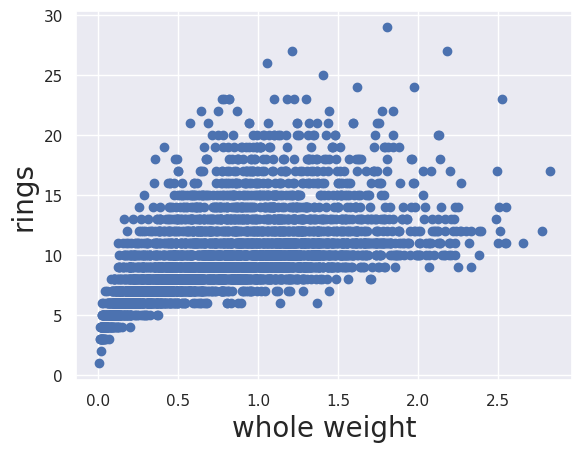

In [100]:
# plot 1: whole weight
plt.scatter(data["whole weight"], data["rings"])
plt.ylabel("rings", size=20)
plt.xlabel("whole weight", size=20)

Text(0.5, 0, 'sex')

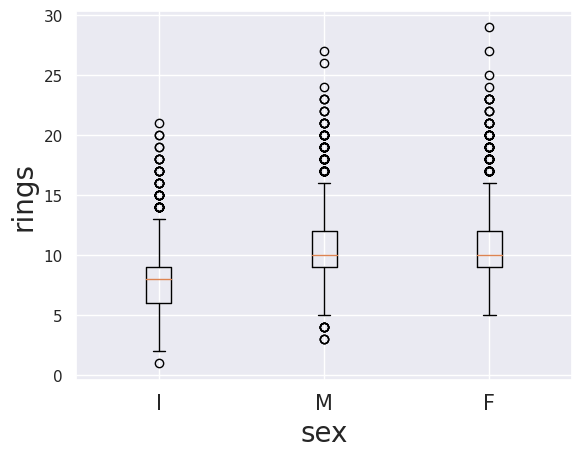

In [101]:
# plot 2: sex
plt.boxplot(data[data.sex == "I"]["rings"], positions=[1])
plt.boxplot(data[data.sex == "M"]["rings"], positions=[2])
plt.boxplot(data[data.sex == "F"]["rings"], positions=[3])

plt.xticks(ticks=[1, 2, 3], labels=["I", "M", "F"], size=15)
plt.ylabel("rings", size=20)
plt.xlabel("sex", size=20)

<Axes: >

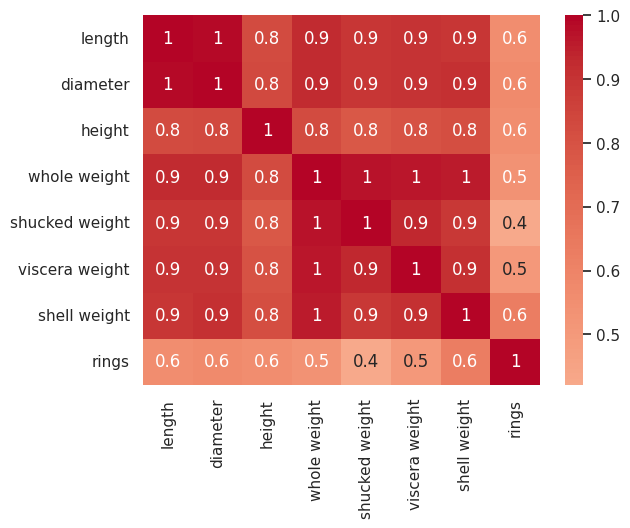

In [102]:
# plot 3: Correlation heatmap
cont = [
    "length",
    "diameter",
    "height",
    "whole weight",
    "shucked weight",
    "viscera weight",
    "shell weight",
    "rings",
]
corr_matrix = pd.DataFrame(data[cont], columns=cont).corr()

sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".1g")

# Feature Engineering


In [103]:
y = data["rings"]
X = data[["sex", "length", "height", "shucked weight", "viscera weight", "shell weight"]]

In [104]:
# create dummy variables
X["sex.M"] = [1 if s == "M" else 0 for s in X["sex"]]
X["sex.F"] = [1 if s == "F" else 0 for s in X["sex"]]
X["sex.I"] = [1 if s == "I" else 0 for s in X["sex"]]
X = X.drop("sex", axis=1)

X.head()

<ipython-input-104-c238d13e20ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["sex.M"] = [1 if s == "M" else 0 for s in X["sex"]]
<ipython-input-104-c238d13e20ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["sex.F"] = [1 if s == "F" else 0 for s in X["sex"]]


,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


# Modelling


In [105]:
# train model
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 0, 'Actual')

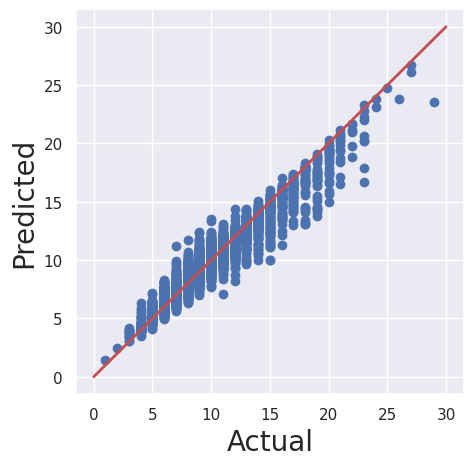

In [106]:
# get predictions
y_pred = model.predict(X)

# model evaluation
plt.figure(figsize=(5, 5))

plt.scatter(y, y_pred)
plt.plot([0, 30], [0, 30], color="r", linestyle="-", linewidth=2)

plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)

# 1) Standard SHAP values


In [107]:
# get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)
# shap_values = explainer(X[0:100])

In [108]:
explainer

In [109]:
np.shape(shap_values.values)

(4177, 8)

# Feature Importance

In [110]:
Explainer=shap.Explainer(model)
shap_values=Explainer(X)

In [111]:
np.sort(np.abs(shap_values.values).mean(axis=0))[::-1]

array([1.7100525 , 0.90023315, 0.4161431 , 0.30628774, 0.23723944,
       0.16077527, 0.05651404, 0.05406597], dtype=float32)

## Waterfall plot


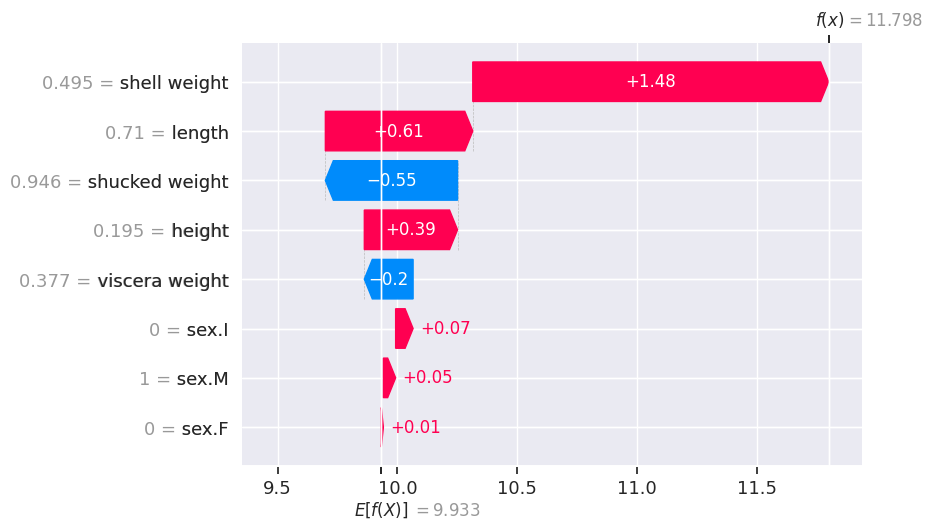

In [112]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[4176])

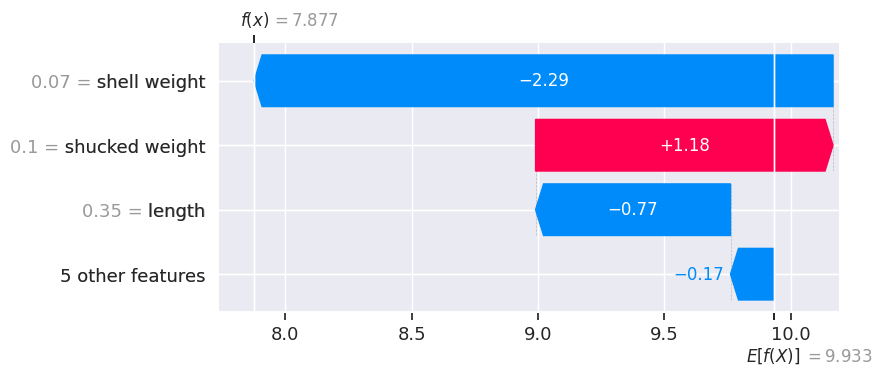

In [113]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[1], max_display=4)

# 2) SHAP aggregations


<b>Note:</b> from here on we only consider the continous target variable


## Force plot


In [114]:
# force plot
shap.plots.force(shap_values[0])

## Stacked force plot


In [115]:
# stacked force plot
shap.plots.force(shap_values[0:100])

## Absolute Mean SHAP


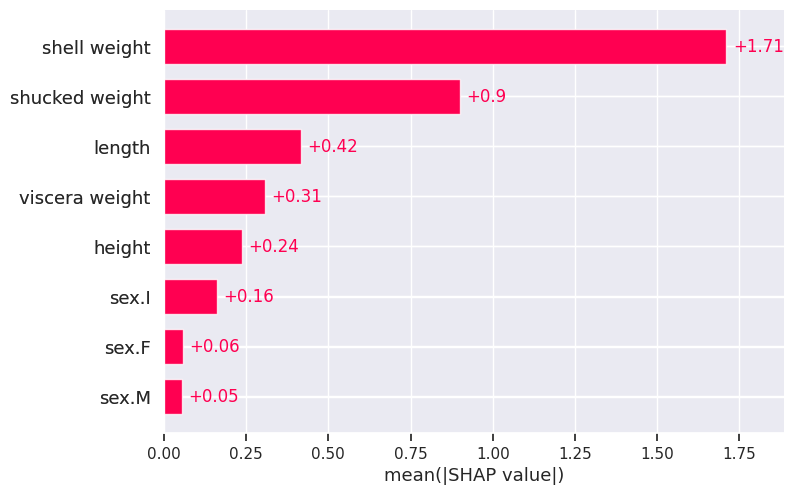

In [116]:
# mean SHAP
shap.plots.bar(shap_values)

## Beeswarm plot


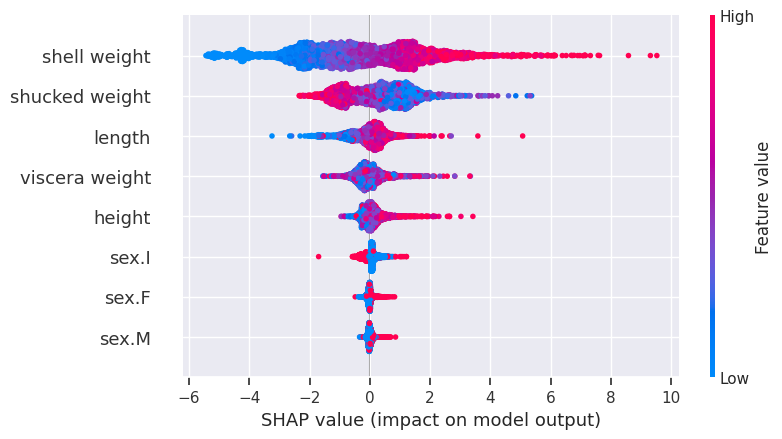

In [117]:
# beeswarm plot
shap.plots.beeswarm(shap_values)

## Violin plot


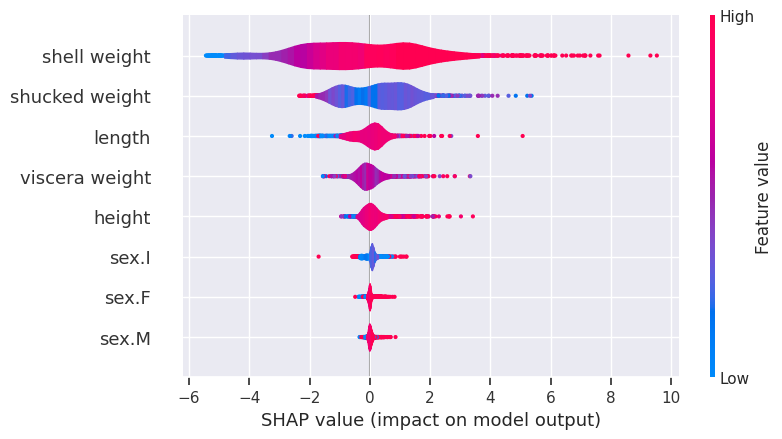

In [118]:
# violin plot
shap.plots.violin(shap_values)

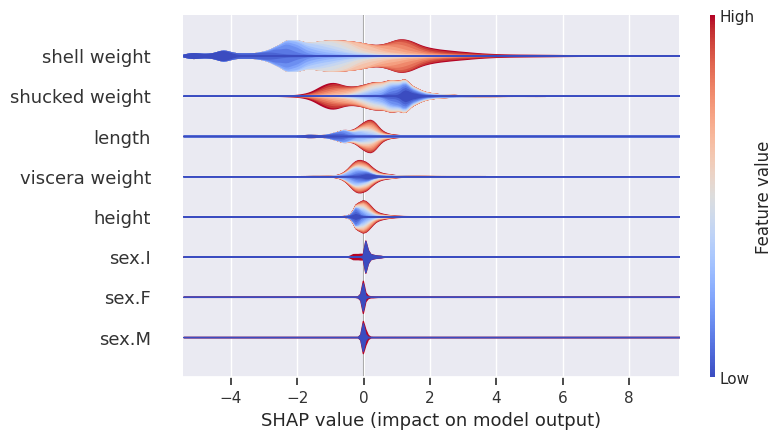

In [119]:
# layered violin plot
shap.plots.violin(shap_values, plot_type="layered_violin")

## Heamap


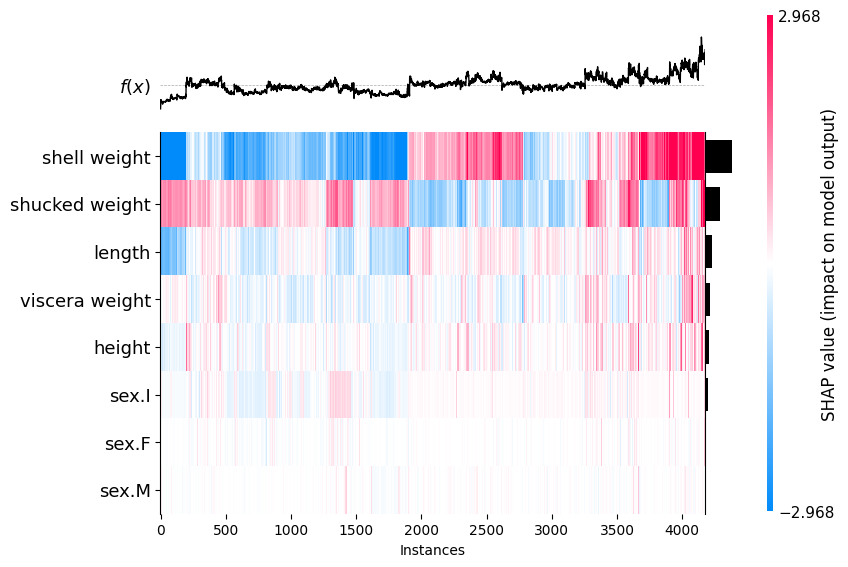

<Axes: xlabel='Instances'>

In [84]:
# heatmap
shap.plots.heatmap(shap_values)

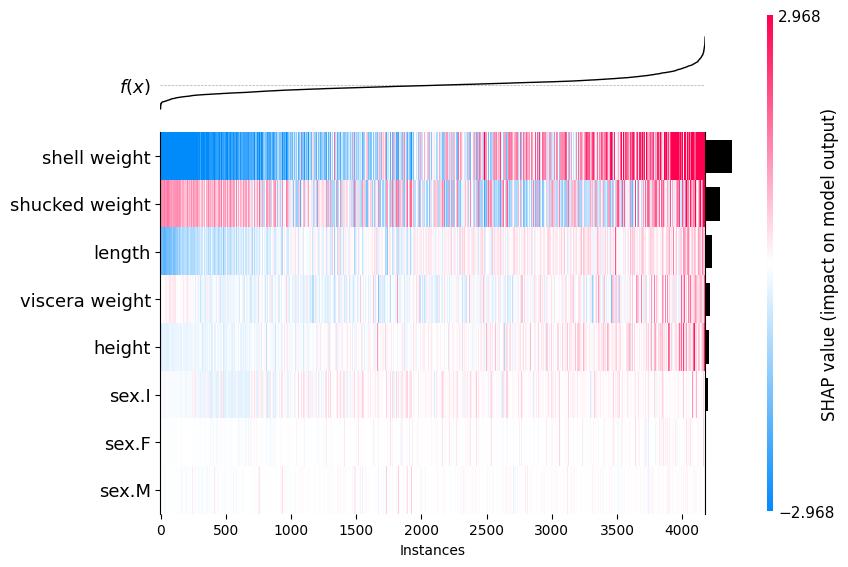

<Axes: xlabel='Instances'>

In [85]:
# order by predictions
order = np.argsort(y_pred)
shap.plots.heatmap(shap_values, instance_order=order)

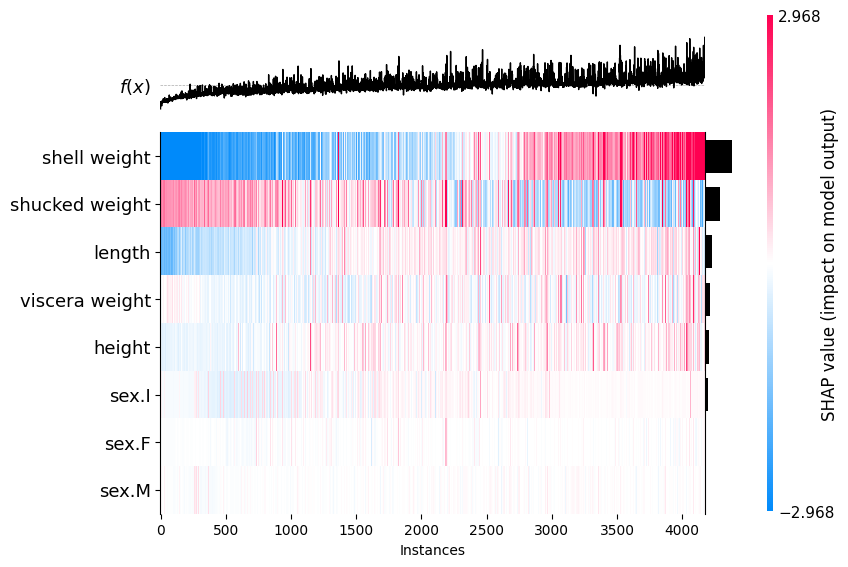

<Axes: xlabel='Instances'>

In [86]:
# order by shell weight value
order = np.argsort(data["shell weight"])
shap.plots.heatmap(shap_values, instance_order=order)

## Dependence plots


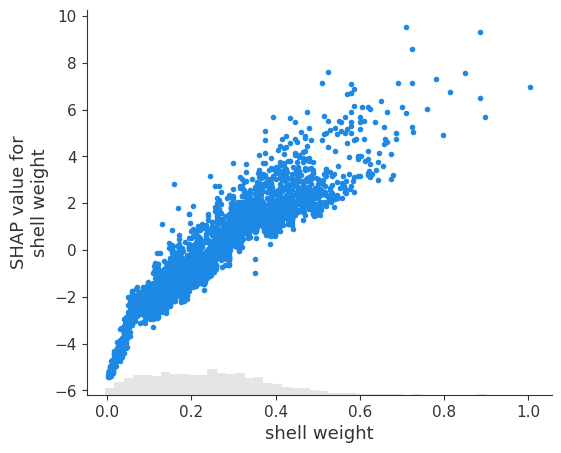

In [87]:
# plot 1: shell weight
shap.plots.scatter(shap_values[:, "shell weight"])

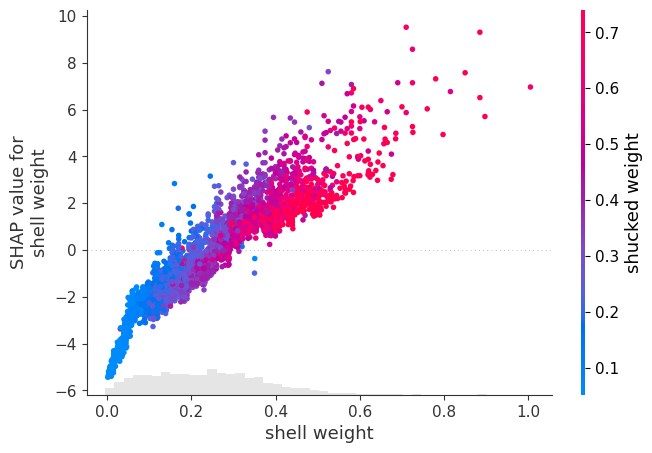

In [88]:
shap.plots.scatter(
    shap_values[:, "shell weight"], color=shap_values[:, "shucked weight"]
)

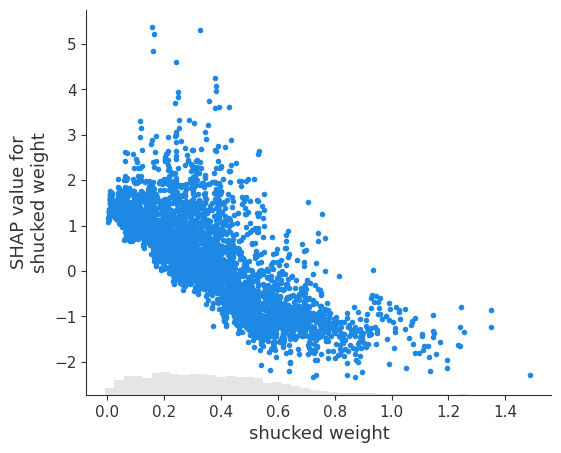

In [89]:
# plot 2: shucked weight
shap.plots.scatter(shap_values[:, "shucked weight"])

# 3) Custom Plots


In [90]:
# output SHAP object
shap_values

.values =
array([[ 0.36806285,  1.0587054 ,  0.94834965, ...,  0.3316413 ,
        -0.04919233,  0.3216473 ],
       [-0.7708986 , -0.21779695,  1.176285  , ...,  0.05278974,
        -0.0395156 ,  0.49588168],
       [ 0.15351889, -0.02277692,  0.47050092, ...,  0.04105941,
         0.04848656,  0.12317639],
       ...,
       [ 0.14958209,  0.32025054, -1.4478747 , ...,  0.04284297,
         0.01527823,  0.02549139],
       [-0.04009023, -0.09120232, -0.919325  , ...,  0.05648781,
         0.05737196,  0.09682811],
       [ 0.61490464,  0.388789  , -0.55129325, ...,  0.05122245,
         0.00867648,  0.07278913]], dtype=float32)

.base_values =
array([9.93266, 9.93266, 9.93266, ..., 9.93266, 9.93266, 9.93266],
      dtype=float32)

.data =
array([[0.455 , 0.095 , 0.2245, ..., 1.    , 0.    , 0.    ],
       [0.35  , 0.09  , 0.0995, ..., 1.    , 0.    , 0.    ],
       [0.53  , 0.135 , 0.2565, ..., 0.    , 1.    , 0.    ],
       ...,
       [0.6   , 0.205 , 0.5255, ..., 1.    , 0.    

In [91]:
np.shape(shap_values.values)

(4177, 8)

In [92]:
X.head()

,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


<Axes: >

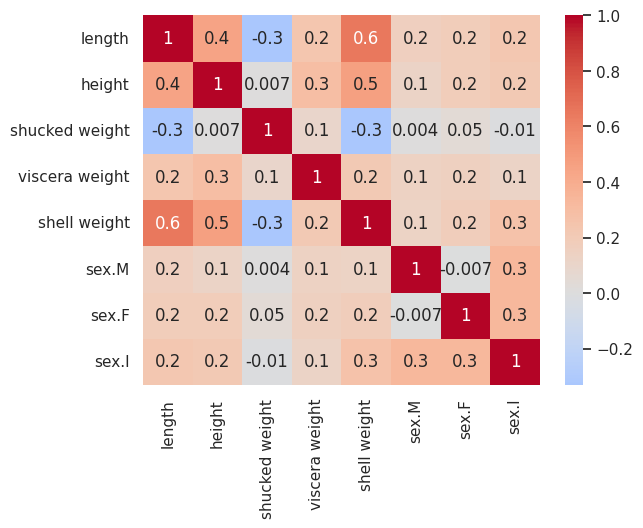

In [93]:
# SHAP correlation plot
corr_matrix = pd.DataFrame(shap_values.values, columns=X.columns).corr()

sns.set(font_scale=1)
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".1g")

# 4. Binary and categorical target variables


### Binary target variable


In [94]:
# binary target varibale
y_bin = [1 if y_ > 10 else 0 for y_ in y]

# train model
model_bin = xgb.XGBClassifier(objective="binary:logistic")
model_bin.fit(X, y_bin)

# get shap values
explainer = shap.Explainer(model_bin)

shap_values_bin = explainer(X)

print(shap_values_bin.shape)

(4177, 8)


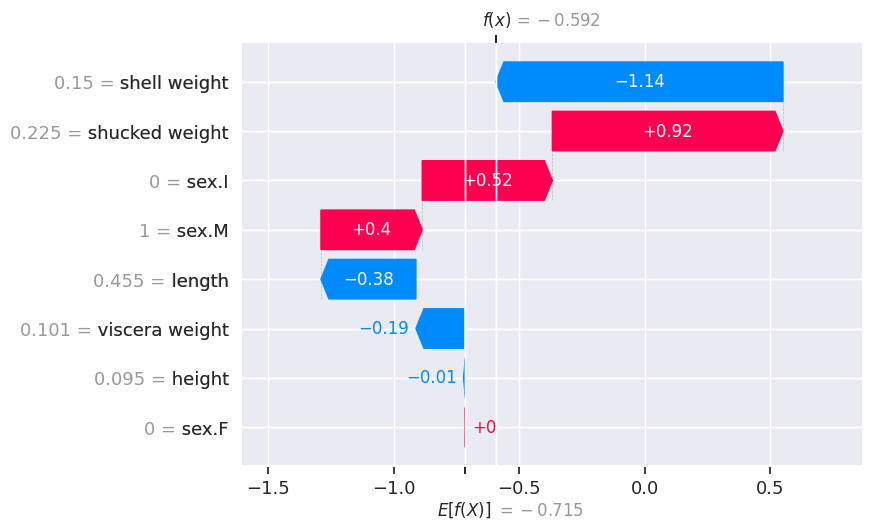

In [120]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values_bin[0])

In [121]:
# waterfall plot for first observation
shap.plots.force(shap_values_bin[0], link="logit")

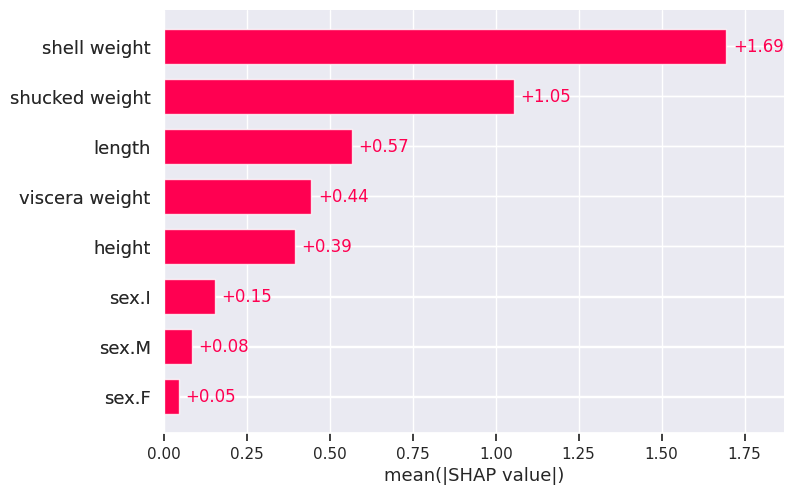

In [122]:
# waterfall plot for first observation
shap.plots.bar(shap_values_bin)

### Categorical target variables


In [95]:
# categorical target varibale
y_cat = [2 if y_ > 12 else 1 if y_ > 8 else 0 for y_ in y]

# train model
model_cat = xgb.XGBClassifier(objective="binary:logistic")
model_cat.fit(X, y_cat)

# get probability predictions
model_cat.predict_proba(X)[0]

array([0.29758084, 0.19655095, 0.50586826], dtype=float32)

In [ ]:
# get shap values
explainer = shap.Explainer(model_cat)
shap_values_cat = explainer(X)

print(np.shape(shap_values_cat))

(4177, 8, 3)


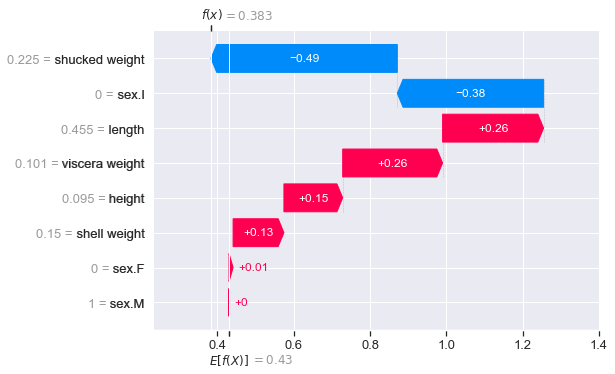

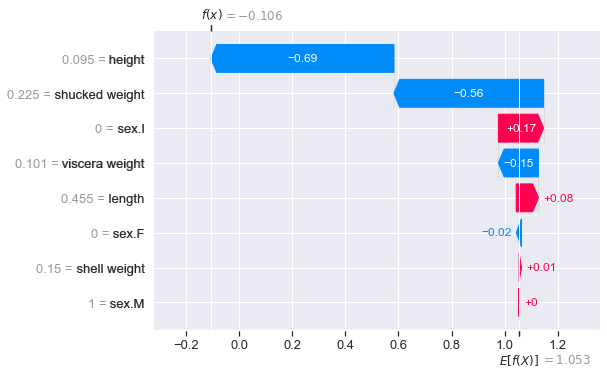

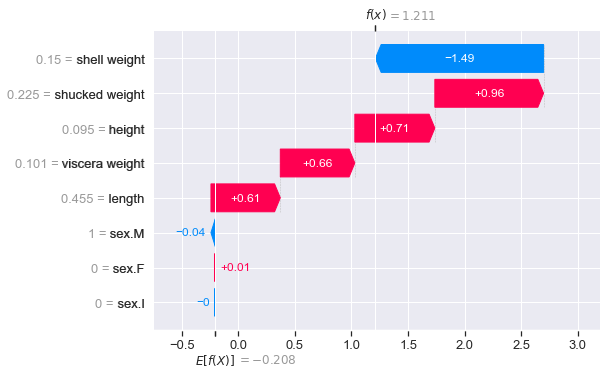

In [ ]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values_cat[0, :, 0])

# waterfall plot for first observation
shap.plots.waterfall(shap_values_cat[0, :, 1])

# waterfall plot for first observation
shap.plots.waterfall(shap_values_cat[0, :, 2])

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# convert softmax to probability
x = [0.383, -0.106, 1.211]
softmax(x)

array([0.25628041, 0.15716122, 0.58655837])

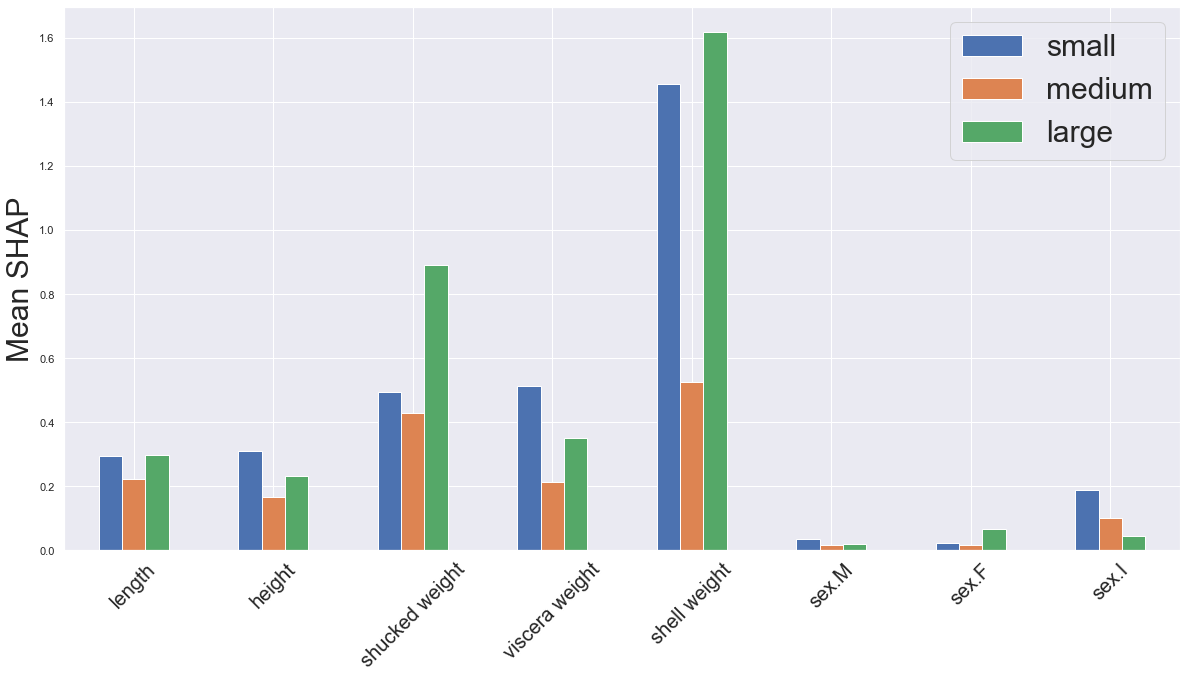

In [ ]:
# calculate mean SHAP values for each class
mean_0 = np.mean(np.abs(shap_values_cat.values[:, :, 0]), axis=0)
mean_1 = np.mean(np.abs(shap_values_cat.values[:, :, 1]), axis=0)
mean_2 = np.mean(np.abs(shap_values_cat.values[:, :, 2]), axis=0)

df = pd.DataFrame({"small": mean_0, "medium": mean_1, "large": mean_2})

# plot mean SHAP values
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df.plot.bar(ax=ax)

ax.set_ylabel("Mean SHAP", size=30)
ax.set_xticklabels(X.columns, rotation=45, size=20)
ax.legend(fontsize=30)

In [ ]:
# get model predictions
preds = model_cat.predict(X)

new_shap_values = []
for i, pred in enumerate(preds):
    # get shap values for predicted class
    new_shap_values.append(shap_values_cat.values[i][:, pred])

# replace shap values
shap_values_cat.values = np.array(new_shap_values)
print(shap_values_cat.shape)

(4177, 8)


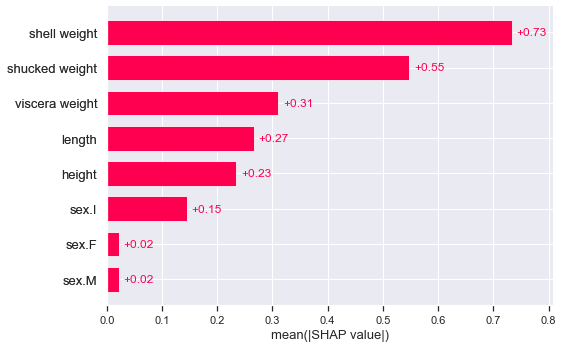

In [ ]:
shap.plots.bar(shap_values_cat)

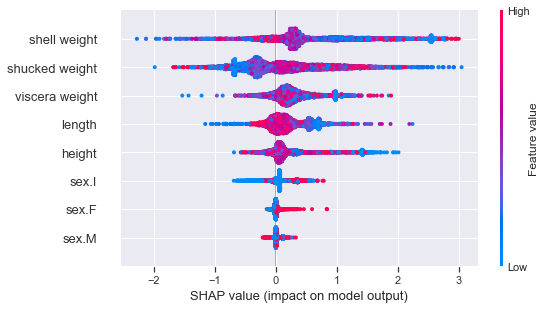

In [ ]:
shap.plots.beeswarm(shap_values_cat)

# 5) SHAP interaction value


In [ ]:
# get SHAP interaction values
explainer = shap.Explainer(model)
shap_interaction = explainer.shap_interaction_values(X)

In [ ]:
# get shape of interaction values
np.shape(shap_interaction)

(4177, 8, 8)

In [ ]:
# SHAP interaction values for first employee
shap_0 = np.round(shap_interaction[0], 2)
pd.DataFrame(shap_0, index=X.columns, columns=X.columns)

,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
length,-0.30,0.44,0.10,-0.18,0.59,0.27,0.04,0.02
height,0.44,-0.26,0.01,-0.09,-0.02,0.16,-0.01,-0.01
shucked weight,0.10,0.01,1.21,0.00,-0.16,0.45,-0.05,0.11
viscera weight,-0.18,-0.09,0.00,-0.20,0.28,0.06,-0.00,0.03
shell weight,0.59,-0.02,-0.16,0.28,-1.87,0.14,0.06,0.14
sex.M,0.27,0.16,0.45,0.06,0.14,-0.30,0.00,0.00
sex.F,0.04,-0.01,-0.05,-0.00,0.06,0.00,-0.07,0.00
sex.I,0.02,-0.01,0.11,0.03,0.14,0.00,0.00,0.13


## Mean SHAP interaction values


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'length'),
  Text(0, 1.5, 'height'),
  Text(0, 2.5, 'shucked weight'),
  Text(0, 3.5, 'viscera weight'),
  Text(0, 4.5, 'shell weight'),
  Text(0, 5.5, 'sex.M'),
  Text(0, 6.5, 'sex.F'),
  Text(0, 7.5, 'sex.I')])

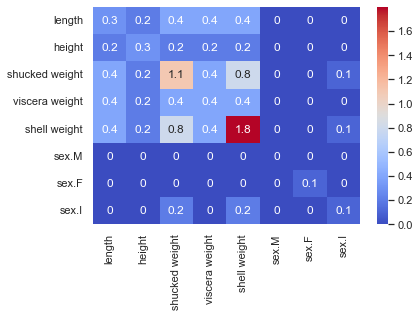

In [ ]:
# get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
mean_shap = np.round(mean_shap, 1)

df = pd.DataFrame(mean_shap, index=X.columns, columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df), df.values * 2, inplace=True)

# display
sns.set(font_scale=1)
sns.heatmap(df, cmap="coolwarm", annot=True)
plt.yticks(rotation=0)

## Dependence plot


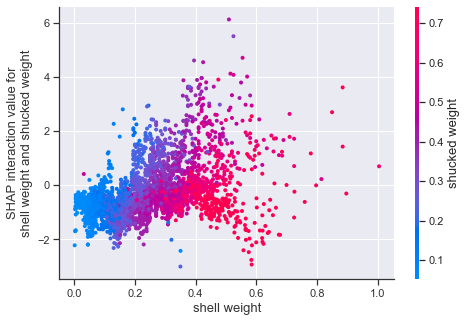

In [ ]:
shap.dependence_plot(
    ("shell weight", "shucked weight"), shap_interaction, X, display_features=X
)

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


Text(0, 0.5, 'shell weight')

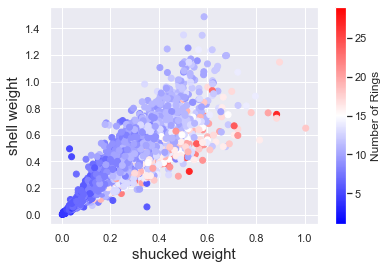

In [ ]:
# interaction between shell weight and shucked weight
plt.scatter(data["shell weight"], data["shucked weight"], c=data["rings"], cmap="bwr")
plt.colorbar(label="Number of Rings", orientation="vertical")

plt.xlabel("shucked weight", size=15)
plt.ylabel("shell weight", size=15)

# 6) SHAP for categorical variables


In [ ]:
X.head()

,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


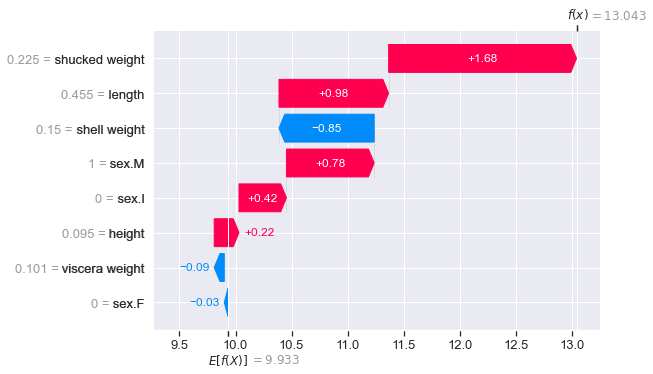

In [ ]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [ ]:
new_shap_values = []

# loop over all shap values:
for values in shap_values.values:
    # sum SHAP values for sex
    sv = list(values)
    sv = sv[0:5] + [sum(sv[5:8])]

    new_shap_values.append(sv)

In [ ]:
# replace shap values
shap_values.values = np.array(new_shap_values)

# replace data with categorical feature values
X_cat = data[
    ["length", "height", "shucked weight", "viscera weight", "shell weight", "sex"]
]
shap_values.data = np.array(X_cat)

# update feature names
shap_values.feature_names = list(X_cat.columns)

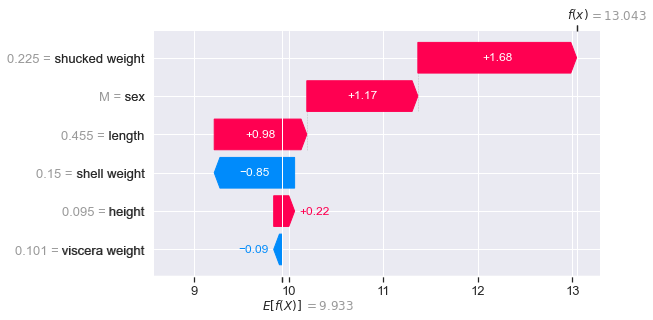

In [ ]:
shap.plots.waterfall(shap_values[0])

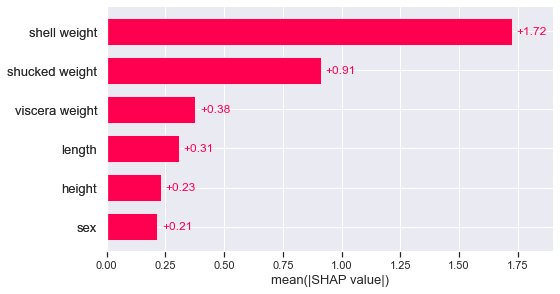

In [ ]:
shap.plots.bar(shap_values)

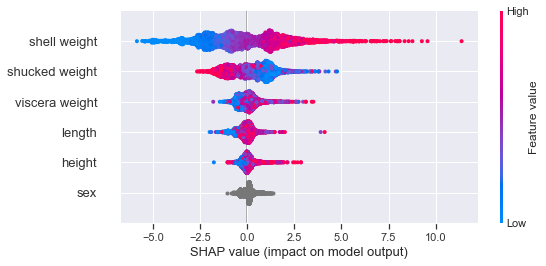

In [ ]:
shap.plots.beeswarm(shap_values)

Text(0.5, 0, 'Sex')

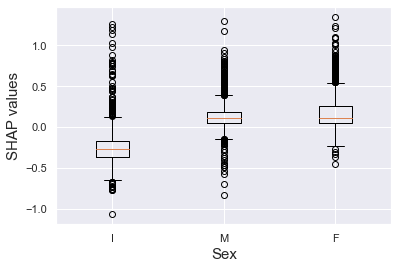

In [ ]:
# get shaply values and data
sex_values = shap_values[:, "sex"].values
sex_data = shap_values[:, "sex"].data
sex_categories = ["I", "M", "F"]

# split sex shap values based on category
sex_groups = []
for s in sex_categories:
    relevant_values = sex_values[sex_data == s]
    sex_groups.append(relevant_values)

# plot boxplot
plt.boxplot(sex_groups, labels=sex_categories)

plt.ylabel("SHAP values", size=15)
plt.xlabel("Sex", size=15)

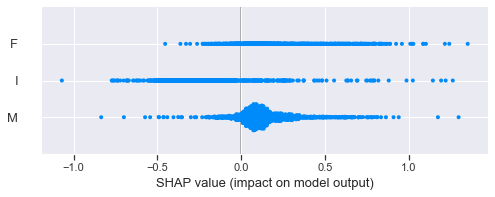

In [ ]:
# create for placeholder SHAP values
shap_values_sex = explainer(X)

# get shaply values and data
sex_values = shap_values[:, "sex"].values
sex_data = shap_values[:, "sex"].data
sex_categories = ["I", "M", "F"]

# create new SHAP values array

# split odor SHAP values by unique odor categories
new_shap_values = [
    np.array(pd.Series(sex_values)[sex_data == s]) for s in sex_categories
]

# each sublist needs to be the same length
max_len = max([len(v) for v in new_shap_values])
new_shap_values = [
    np.append(vs, [np.nan] * (max_len - len(vs))) for vs in new_shap_values
]
new_shap_values = np.array(new_shap_values)

# transpost matrix so categories are columns and SHAP values are rows
new_shap_values = new_shap_values.transpose()

# replace shap values
shap_values_sex.values = np.array(new_shap_values)

# replace data with placeholder array
shap_values_sex.data = np.array([[0] * len(sex_categories)] * max_len)

# replace base data with placeholder array
shap_values_sex.base = np.array([0] * max_len)

# replace feature names with category labels
shap_values_sex.feature_names = list(sex_categories)

# use beeswarm as before
shap.plots.beeswarm(shap_values_sex, color_bar=False)

In [ ]:
import warnings

warnings.filterwarnings("ignore")